# Data Scientist Blogpost "How Electric Vehicles took over the German second-hand car market"

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./autoscout24-germany-dataset.csv')
schema = pd.read_csv('./autoscout24-germany-dataset.csv')

# Understand data

In [2]:
# Understand data - how does the input data look like
df.head()

,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011


In [3]:
# Understand data: How big is the dataset?
df.shape

(46405, 9)

In [4]:
# Get an initial feel for the values in the dataset
df.describe()

,mileage,price,hp,year
count,4.640500e+04,4.640500e+04,46376.000000,46405.000000
mean,7.117786e+04,1.657234e+04,132.990987,2016.012951
std,6.262531e+04,1.930470e+04,75.449284,3.155214
min,0.000000e+00,1.100000e+03,1.000000,2011.000000
25%,1.980000e+04,7.490000e+03,86.000000,2013.000000
50%,6.000000e+04,1.099900e+04,116.000000,2016.000000
75%,1.050000e+05,1.949000e+04,150.000000,2019.000000
max,1.111111e+06,1.199900e+06,850.000000,2021.000000


# Prepare data

In [5]:
# Is there missing data in the dataset?

missing_values = df.isnull().values.any()
print('There are missing values in the dataset:' + str(missing_values))


number_missing_values = df.isnull().sum().sum()
print('There are '+ str(number_missing_values) +' missing values in the dataset')

df.isnull().sum()

There are missing values in the dataset:True
There are 354 missing values in the dataset


mileage        0
make           0
model        143
fuel           0
gear         182
offerType      0
price          0
hp            29
year           0
dtype: int64

In [6]:
# Get the rows with the missing values
df_missing_values = df[df.isnull().any(axis=1)]
df_missing_values

,mileage,make,model,fuel,gear,offerType,price,hp,year
243,93850,Renault,Grand Scenic,Diesel,NaN,Used,7990,110.0,2012
347,52753,Lada,Vesta,Gasoline,NaN,Used,8000,106.0,2017
365,3500,Others,NaN,Electric,Manual,Used,5500,38.0,2018
482,36018,Mitsubishi,Space Star,Gasoline,Manual,Used,6222,NaN,2015
612,46850,Suzuki,Alto,Gasoline,NaN,Used,3999,68.0,2011
...,...,...,...,...,...,...,...,...,...
46114,35,Kia,NaN,Electric/Gasoline,Automatic,Pre-registered,30440,141.0,2021
46120,35,Kia,NaN,Electric,Automatic,Pre-registered,32440,204.0,2021
46237,2000,Tesla,NaN,Electric,Automatic,Used,57020,487.0,2021
46326,45,BMW,iX3,Electric,NaN,Used,58000,286.0,2021


In [7]:
# Analyse missing values by columns
df[df['model'].isnull()] # other two columns with NaNs: 'gear', 'hp'

# Looking at the data, the missing model is not a problem in our case, since we are focus our analysis on the propulsion system.
# The same applies for the Horse Power and Gear (xEVs are automatic, anyway)

,mileage,make,model,fuel,gear,offerType,price,hp,year
365,3500,Others,NaN,Electric,Manual,Used,5500,38.0,2018
2001,2900,Others,NaN,Electric,Automatic,Used,7900,5.0,2018
2009,60866,Opel,NaN,Gasoline,Manual,Used,12290,82.0,2019
2019,3550,Opel,NaN,Gasoline,Manual,Used,15800,110.0,2019
2496,3000,Audi,NaN,Electric,Automatic,Demonstration,172450,598.0,2021
...,...,...,...,...,...,...,...,...,...
46074,1,Others,NaN,Gasoline,Manual,Pre-registered,23990,150.0,2021
46102,1,Others,NaN,Gasoline,Manual,Pre-registered,23990,150.0,2021
46114,35,Kia,NaN,Electric/Gasoline,Automatic,Pre-registered,30440,141.0,2021
46120,35,Kia,NaN,Electric,Automatic,Pre-registered,32440,204.0,2021


# Model Data

# Business related question 1: How has the share of electric vehicles in the second hand market developed over the years?

In [8]:
#EVs_per_year = df.value_counts(['year', 'fuel'])
EVs_per_year = df.groupby(['year', 'fuel'])['price'].count().to_frame(name = 'number of vehicles').reset_index()
EVs_per_year

,year,fuel,number of vehicles
0,2011,-/- (Fuel),1
1,2011,CNG,7
2,2011,Diesel,1419
3,2011,Electric,5
4,2011,Electric/Gasoline,22
...,...,...,...
94,2021,Electric/Diesel,11
95,2021,Electric/Gasoline,406
96,2021,Gasoline,3083
97,2021,LPG,21


In [9]:
# Group dataset by respective year and propulsion system
vehicles_per_year = EVs_per_year.groupby(['year','fuel'])['number of vehicles'].sum().unstack()

# Sum vehicles by propulsion system and years
vehicles_per_year['VehicleSum'] = vehicles_per_year.sum(axis=1)

# Get relative share in years for propulsion systems
vehicles_per_year = vehicles_per_year.div(vehicles_per_year.VehicleSum, axis='index')
vehicles_per_year

#vehicles_per_year.plot(subplots=True);

fuel,-/- (Fuel),CNG,Diesel,Electric,Electric/Diesel,Electric/Gasoline,Ethanol,Gasoline,Hydrogen,LPG,Others,VehicleSum
year,,,,,,,,,,,,
2011,0.000243,0.001702,0.345088,0.001216,NaN,0.005350,0.000243,0.642023,NaN,0.004134,NaN,1.0
2012,0.000711,0.001895,0.356314,0.004264,0.000948,0.007107,0.000237,0.624023,NaN,0.003554,0.000948,1.0
2013,0.000469,0.002579,0.355602,0.006798,0.000703,0.009611,NaN,0.622363,NaN,0.001406,0.000469,1.0
2014,0.000718,0.004067,0.356220,0.014115,0.000478,0.006459,NaN,0.613636,NaN,0.002871,0.001435,1.0
2015,0.001424,0.003560,0.369008,0.016137,0.000237,0.007594,NaN,0.598007,NaN,0.002610,0.001424,1.0
2016,0.000703,0.001172,0.378575,0.018753,0.000469,0.009845,NaN,0.588373,NaN,0.001641,0.000469,1.0
2017,0.001184,0.001184,0.412029,0.015155,0.001658,0.014682,NaN,0.551504,0.000237,0.002131,0.000237,1.0
2018,0.000237,0.001894,0.391191,0.013261,0.000947,0.018470,NaN,0.569974,NaN,0.002131,0.001894,1.0
2019,NaN,0.004961,0.286086,0.025278,0.001181,0.024333,NaN,0.654855,NaN,0.000472,0.002835,1.0


In [10]:
# Transpose dataframe for plotting purposes
vehicles_per_year_transposed = vehicles_per_year.T
# drop row "sum"
vehicles_per_year_transposed = vehicles_per_year_transposed.drop(index='VehicleSum')
#show dataframe
vehicles_per_year_transposed

year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
fuel,,,,,,,,,,,
-/- (Fuel),0.000243,0.000711,0.000469,0.000718,0.001424,0.000703,0.001184,0.000237,NaN,0.000233,0.000239
CNG,0.001702,0.001895,0.002579,0.004067,0.003560,0.001172,0.001184,0.001894,0.004961,0.003033,0.001674
Diesel,0.345088,0.356314,0.355602,0.356220,0.369008,0.378575,0.412029,0.391191,0.286086,0.244984,0.117675
Electric,0.001216,0.004264,0.006798,0.014115,0.016137,0.018753,0.015155,0.013261,0.025278,0.028931,0.035398
Electric/Diesel,NaN,0.000948,0.000703,0.000478,0.000237,0.000469,0.001658,0.000947,0.001181,0.003266,0.002631
Electric/Gasoline,0.005350,0.007107,0.009611,0.006459,0.007594,0.009845,0.014682,0.018470,0.024333,0.073495,0.097106
Ethanol,0.000243,0.000237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gasoline,0.642023,0.624023,0.622363,0.613636,0.598007,0.588373,0.551504,0.569974,0.654855,0.641391,0.737383
Hydrogen,NaN,NaN,NaN,NaN,NaN,NaN,0.000237,NaN,NaN,NaN,NaN


<ipython-input-11-378d5aaa3c73>:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([year2012, year2013, year2014, year2015, year2016, year2017, year2018, year2019, year2020, year2021],     # The line objects


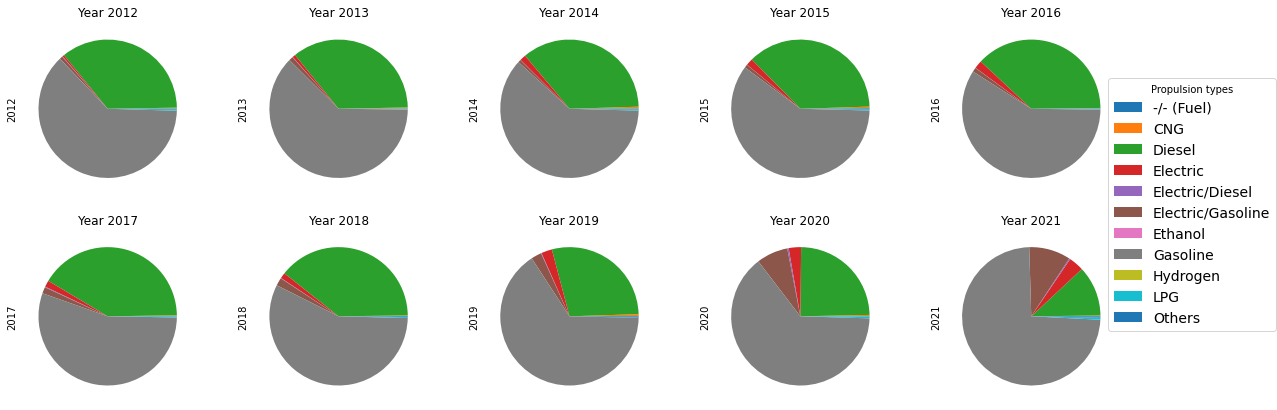

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,7))

# Get labels for subplot
labels = vehicles_per_year_transposed.index.tolist()

#vehicles_per_year.T[2011].plot.pie(ax=axes[0, 0]);
#axes[0, 0].set_title("Year 2011");

year2012 = vehicles_per_year_transposed[2012].plot.pie(ax=axes[0, 0], labels=['','','','','','','','','','','']);
axes[0, 0].set_title("Year 2012");

year2013 =vehicles_per_year_transposed[2013].plot.pie(ax=axes[0, 1], labels=['','','','','','','','','','','']);
axes[0, 1].set_title("Year 2013");

year2014 =vehicles_per_year_transposed[2014].plot.pie(ax=axes[0, 2], labels=['','','','','','','','','','','']);
axes[0, 2].set_title("Year 2014");

year2015 =vehicles_per_year_transposed[2015].plot.pie(ax=axes[0, 3], labels=['','','','','','','','','','','']);
axes[0, 3].set_title("Year 2015");

year2016 =vehicles_per_year_transposed[2016].plot.pie(ax=axes[0, 4], labels=['','','','','','','','','','','']);
axes[0, 4].set_title("Year 2016");

year2017 =vehicles_per_year_transposed[2017].plot.pie(ax=axes[1, 0], labels=['','','','','','','','','','','']);
axes[1, 0].set_title("Year 2017");

year2018 =vehicles_per_year_transposed[2018].plot.pie(ax=axes[1, 1], labels=['','','','','','','','','','','']);
axes[1, 1].set_title("Year 2018");

year2019 =vehicles_per_year_transposed[2019].plot.pie(ax=axes[1, 2], labels=['','','','','','','','','','','']);
axes[1, 2].set_title("Year 2019");

year2020 =vehicles_per_year_transposed[2020].plot.pie(ax=axes[1, 3], labels=['','','','','','','','','','','']);
axes[1, 3].set_title("Year 2020");

year2021 =vehicles_per_year_transposed[2021].plot.pie(ax=axes[1, 4], labels=['','','','','','','','','','','']);
axes[1, 4].set_title("Year 2021");

# Create the legend
fig.legend([year2012, year2013, year2014, year2015, year2016, year2017, year2018, year2019, year2020, year2021],     # The line objects
           labels=labels,   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Propulsion types",  # Title for the legend
           fontsize=14
           )

plt.savefig('propulsionshares_per_year.png')

# Business related question 2:  Offer electric vehicles less performance than their conventional counterparts? If so, became xEVs more powerful with the Ev-technology maturing?

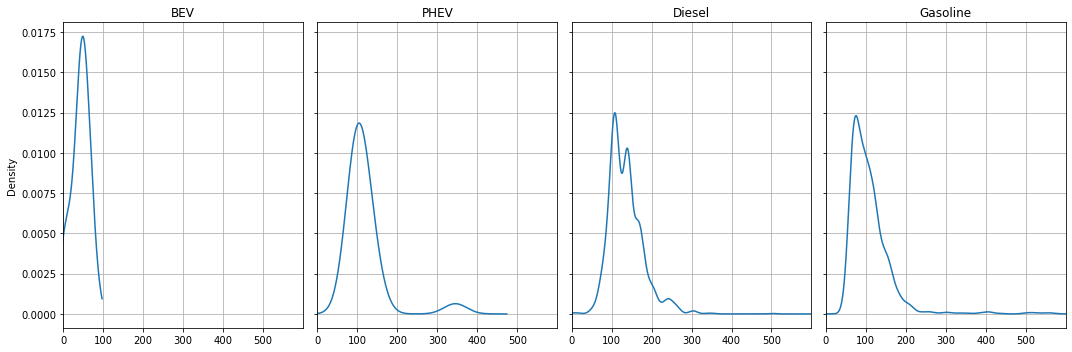

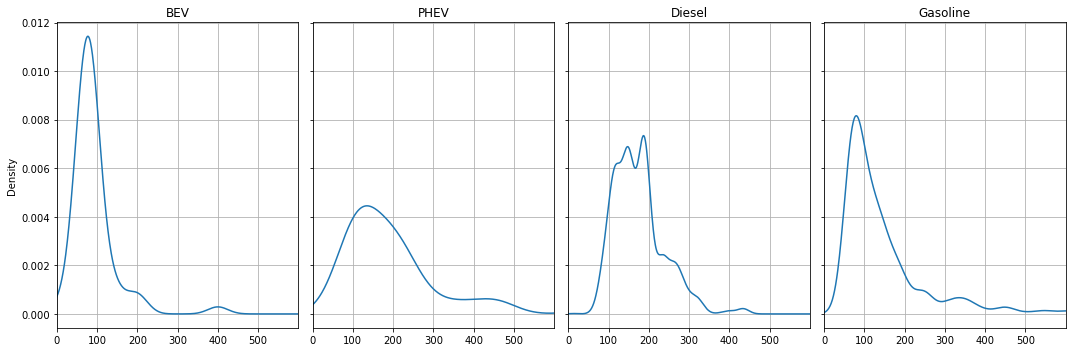

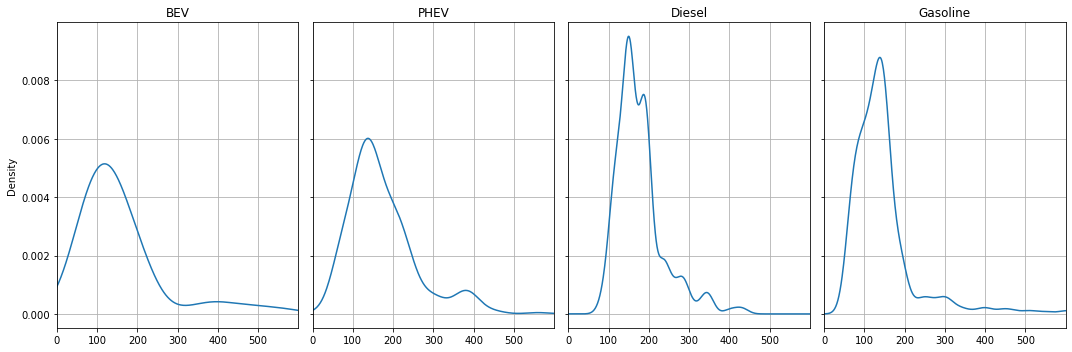

In [12]:
# Years to observe: 2011 - start year; 2018 - EV break through; 2020 - last complete year in data set 
years = [2011, 2018, 2020]

# function to plot performance in years
def analye_performance(year_to_observe):
    
    # select propulsion technologies
    electric = df[(df.fuel=='Electric') & (df.year == year_to_observe)]
    gasoline = df[(df.fuel=='Gasoline') & (df.year == year_to_observe)]
    diesel = df[(df.fuel=='Diesel') & (df.year == year_to_observe)]
    electric_gasoline = df[(df.fuel=='Electric/Gasoline') & (df.year == year_to_observe)]

    # Generate subplot
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5), sharex=True, sharey=True)


    # Four subplots with one plot for each propulsion type
    electric.hp.plot(kind='density', ax=axes[0], title='BEV', xlabel='kW', grid=True, xticks=[-100,0, 100, 200, 300, 400, 500], xlim=[0,600])
    electric_gasoline.hp.plot(kind='density', ax=axes[1], title='PHEV', grid=True)
    diesel.hp.plot(kind='density', ax=axes[2], title='Diesel', grid=True) 
    gasoline.hp.plot(kind='density',ax=axes[3], title='Gasoline', grid=True) 

    # Do proper space alignment of subplots
    fig.tight_layout()

    # savefig
    plt.savefig('Performance_Propulsion_Types_' + str(year_to_observe) + '.png')

# loop through years
for i in years:
    analye_performance(i)

# Business related question 3: Are EVs only used on shorter distances and therefore have shorter total mileage?

In [13]:
# Calculate vehicle age in data set and annual vehicle kilometers travelled
df['age'] = 2021 - df['year']
df['vkt/anno'] = df['mileage'] / (df['age']+1)


# Group to find biggest group of EVs in dataset 
group_vehicles_together = df.groupby(['make', 'model','fuel'])
group_vehicles_together.agg(np.size)

mileage  gear  offerType  price     hp  \
make   model            fuel                                               
Abarth 500              Gasoline       12    12         12     12   12.0   
       595              Gasoline       11    11         11     11   11.0   
       595 Competizione Gasoline        4     4          4      4    4.0   
       595 Turismo      Gasoline        5     5          5      5    5.0   
       595C             Gasoline        7     7          7      7    7.0   
...                                   ...   ...        ...    ...    ...   
smart  forFour          Electric       31    31         31     31   31.0   
                        Gasoline      213   213        213    213  213.0   
       forTwo           Diesel         21    21         21     21   21.0   
                        Electric       70    70         70     70   70.0   
                        Gasoline      634   634        634    634  634.0   

                                  year  age  vkt/anno  
make   model            fuel                           
Abarth 500              Gasoline    12   12      12.0  
       595              Gasoline    11   11      11.0  
       595 Competizione Gasoline     4    4       4.0  
       595 Turismo      Gasoline     5    5       5.0  
       595C             Gasoline     7    7       7.0  
...                                ...  ...       ...  
smart  forFour          Electric    31   31      31.0  
                        Gasoline   213  213     213.0  
       forTwo           Diesel      21   21      21.0  
                        Electric    70   70      70.0  
                        Gasoline   634  634     634.0  

[1477 rows x 8 columns]

In [14]:
# Analyse Smart vehicles
gasoline_smart = group_vehicles_together.get_group(('smart', 'forTwo', 'Gasoline')) # (('smart', 'forTwo', 'Electric'))
electric_smart = group_vehicles_together.get_group(('smart', 'forTwo', 'Electric')) # (('smart', 'forTwo', 'Electric'))

# Generate new dataframe only with mileage to ease plotting purpose
smart = pd.DataFrame([gasoline_smart['vkt/anno'], electric_smart['vkt/anno']]).transpose()
smart.columns = ['Smart Gasoline', 'Smart Electric']

print(gasoline_smart.mean())
print(electric_smart.mean())

mileage     56906.460568
price        7584.470032
hp             73.317035
year         2014.624606
age             6.375394
vkt/anno     7748.851545
dtype: float64
mileage     24189.571429
price       11509.128571
hp             70.594203
year         2017.214286
age             3.785714
vkt/anno     4430.553696
dtype: float64


In [15]:
# Analyse Golf vehicles
gasoline_golf = group_vehicles_together.get_group(('Volkswagen', 'Golf', 'Gasoline')) # (('smart', 'forTwo', 'Electric'))
electric_golf = group_vehicles_together.get_group(('Volkswagen', 'Golf', 'Electric')) # (('smart', 'forTwo', 'Electric'))

# Generate new dataframe only with mileage to ease plotting purpose
golf = pd.DataFrame([gasoline_golf['vkt/anno'], electric_golf['vkt/anno']]).transpose()
golf.columns = ['Golf Gasoline', 'Golf Electric']
print(gasoline_golf.mean())
print(electric_golf.mean())

mileage     71378.738650
price       14055.105521
hp            124.465031
year         2015.138650
age             5.861350
vkt/anno     9493.417535
dtype: float64
mileage     24096.777778
price       20925.259259
hp            131.555556
year         2018.148148
age             2.851852
vkt/anno     5647.199295
dtype: float64


In [16]:
# Analyse Hyundai Ioniq vehicles
gasoline_ioniq = group_vehicles_together.get_group(('Hyundai', 'Ioniq', 'Gasoline')) # (('smart', 'forTwo', 'Electric'))
electric_ioniq = group_vehicles_together.get_group(('Hyundai', 'Ioniq', 'Electric')) # (('smart', 'forTwo', 'Electric'))

# Generate new dataframe only with mileage to ease plotting purpose
ioniq = pd.DataFrame([gasoline_ioniq['vkt/anno'], electric_ioniq['vkt/anno']]).transpose()
ioniq.columns = ['Ioniq Gasoline', 'Ioniq Electric']

print(gasoline_ioniq.mean())
print(electric_ioniq.mean())

mileage     13199.000000
price       21038.333333
hp            125.500000
year         2018.500000
age             2.500000
vkt/anno     3109.075000
dtype: float64
mileage      4894.733333
price       30108.200000
hp            139.466667
year         2020.066667
age             0.933333
vkt/anno     1956.262222
dtype: float64


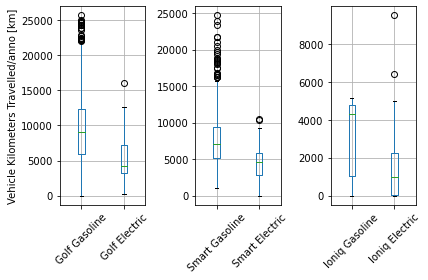

In [17]:
# Generate Subplot with one row and three columns to show VKT analysis for electric and gasoline vehicle
fig, axes = plt.subplots(nrows=1, ncols=3)

# Three subplots with one plot for each model
golf.boxplot(ax=axes[0], column=['Golf Gasoline', 'Golf Electric'], rot=45).set_ylabel('Vehicle Kilometers Travelled/anno [km]')
smart.boxplot(ax=axes[1], column=['Smart Gasoline', 'Smart Electric'], rot=45)
ioniq.boxplot(ax=axes[2], column=['Ioniq Gasoline', 'Ioniq Electric'], rot=45)

# Do proper space alignment of subplots
fig.tight_layout()

# savefig
plt.savefig('Annual VKT Comparison.png')
